# Dataset Concatenation Demo

Simple demo showing:
1. Toy dataset (5 samples)
2. Synthetic dataset (5 samples) 
3. ConcatDataset for stacking them

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import torch
import matplotlib.pyplot as plt
from preprocessing.synthetic import LinearTrendDataset
from preprocessing.transform.concat_dataset import ConcatDataset
from preprocessing.transform.dataset_builder import Builder

torch.manual_seed(42)

## 1. Create Toy Dataset (5 sine waves)

In [3]:
# Create 5 simple sine waves
sequence_length = 20
t = torch.linspace(0, 2*torch.pi, sequence_length)

toy_data = []
for i in range(5):
    frequency = 1.0 + i * 0.5  # Different frequencies
    sine_wave = torch.sin(frequency * t)
    toy_data.append(sine_wave.unsqueeze(-1))  # Shape: (20, 1)

print(f"Created {len(toy_data)} toy sequences, each shape: {toy_data[0].shape}")

Created 5 toy sequences, each shape: torch.Size([20, 1])


## 2. Create Synthetic Dataset (5 linear trends)

In [4]:
# Create 5 synthetic linear trends
synthetic_dataset = LinearTrendDataset(
    sequence_length=sequence_length,
    num_sequences=5,
    trend_slope=0.1,
    noise_std=0.1,
    seed=42
)

synthetic_data = list(synthetic_dataset)
print(f"Created {len(synthetic_data)} synthetic sequences, each shape: {synthetic_data[0].shape}")

Created 5 synthetic sequences, each shape: torch.Size([20, 1])


## 3. Concatenate Datasets

In [5]:
# Sequential concatenation (default)
concat_dataset = ConcatDataset([iter(toy_data), iter(synthetic_data)])
concat_result = list(concat_dataset)

print(f"Concatenated dataset: {len(concat_result)} sequences")
print(f"First 5 are toy data, next 5 are synthetic")

# Interleaved sampling
interleaved_dataset = ConcatDataset(
    [iter(toy_data), iter(synthetic_data)], 
    sampling_ratios=[0.6, 0.4],
    seed=42
)
interleaved_result = list(interleaved_dataset)

print(f"\nInterleaved dataset: {len(interleaved_result)} sequences")
print(f"Mixed order based on 60/40 ratio")

Concatenated dataset: 10 sequences
First 5 are toy data, next 5 are synthetic

Interleaved dataset: 10 sequences
Mixed order based on 60/40 ratio


## 4. Visualize Results

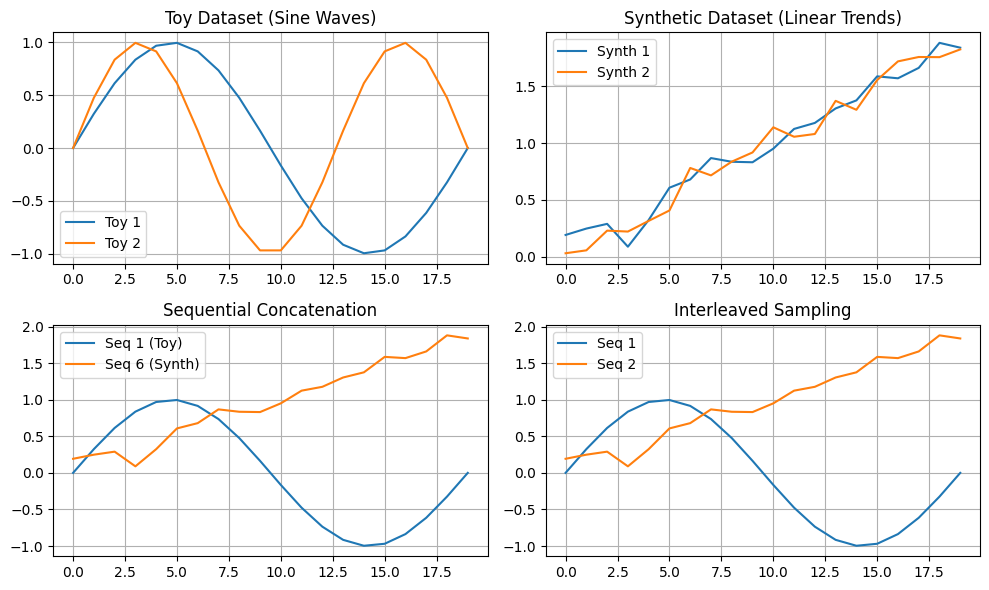

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Show original datasets
axes[0, 0].plot(toy_data[0][:, 0].numpy(), label='Toy 1')
axes[0, 0].plot(toy_data[1][:, 0].numpy(), label='Toy 2')
axes[0, 0].set_title('Toy Dataset (Sine Waves)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(synthetic_data[0][:, 0].numpy(), label='Synth 1')
axes[0, 1].plot(synthetic_data[1][:, 0].numpy(), label='Synth 2')
axes[0, 1].set_title('Synthetic Dataset (Linear Trends)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Show concatenated results
axes[1, 0].plot(concat_result[0][:, 0].numpy(), label='Seq 1 (Toy)')
axes[1, 0].plot(concat_result[5][:, 0].numpy(), label='Seq 6 (Synth)')
axes[1, 0].set_title('Sequential Concatenation')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(interleaved_result[0][:, 0].numpy(), label='Seq 1')
axes[1, 1].plot(interleaved_result[1][:, 0].numpy(), label='Seq 2')
axes[1, 1].set_title('Interleaved Sampling')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 5. Using with Builder Pattern

In [7]:
# Apply transformations using Builder
processed = (
    Builder(ConcatDataset([iter(toy_data), iter(synthetic_data)]))
    .map(lambda x: x / x.std())  # Normalize by std
    .batch(3)  # Batch into groups of 3
    .build()
)

batches = list(processed)
print(f"Created {len(batches)} batches")
print(f"First batch has {len(batches[0])} sequences")
print(f"Each sequence shape: {batches[0][0].shape}")

# Verify normalization
first_seq = batches[0][0]
print(f"\nFirst sequence - Mean: {first_seq.mean():.3f}, Std: {first_seq.std():.3f}")

Created 4 batches
First batch has 3 sequences
Each sequence shape: torch.Size([20, 1])

First sequence - Mean: 0.000, Std: 1.000


## Summary

- **ConcatDataset** concatenates datasets sequentially or with interleaved sampling
- **Sequential mode**: All from first dataset, then all from second
- **Interleaved mode**: Sample according to specified ratios
- Works seamlessly with Builder pattern for transformations